# 05 Alternative regression model using MCMC + maximum likelihood 

> Implemented using metropolis hastings

In [1]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [2]:
#|default_exp core.05_alt_regression_model

In [3]:
#|hide 
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj 
from dementia_inequalities import const, log, utils, tools 
import adu_proj.utils as adutils 

In [5]:
#|export 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression


---

## Log normal distribution 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$


In [137]:
#|export 

def shift_log_normal_pdf(x:np.array, 
                         delta:int, # shift parameter
                         mu:int, # mean of the variables log
                         sigma:int): # standard deviation of the variables log
    print(f'x shape:{x.shape}')
    delta = delta*np.ones(len(x)).T
    mu = mu*np.ones(len(x)).T
    print(f'shape of delta:{delta.shape}')
    x_shift = np.subtract(x.squeeze(), delta.squeeze())
    print(f'shifted x shape: {x_shift.shape}')
    norm_const = 1/((x_shift)*sigma*np.sqrt(2*np.pi))
    print(f'norm constant: {norm_const.shape}')
    exp_part = np.exp(-(1/(2*sigma**2))*(np.log(np.subtract(x_shift.squeeze(), mu.squeeze()))**2))
    return norm_const*exp_part


def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/2581223006.py:9: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)


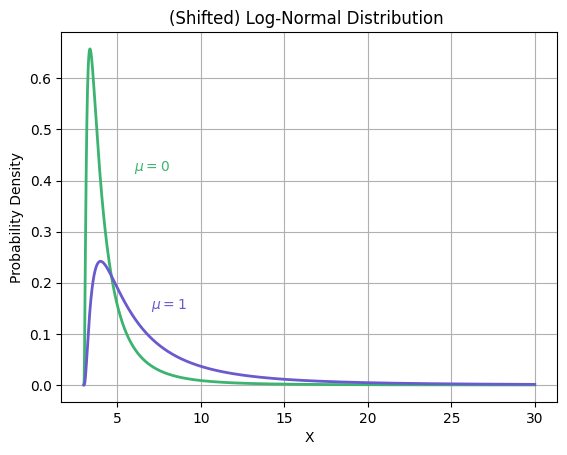

In [7]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
mu_1 = 1
sigma = 1  # Standard deviation
shift = 3 # Shift 

x = np.arange(1, 30, 0.01)

pdf_x_mu0 = shift_log_normal_pdf(x, shift, mu_0, sigma)
pdf_x_mu1 = shift_log_normal_pdf(x, shift, mu_1, sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(6, 0.42, '$\mu=0$', color='mediumseagreen')
plt.plot(x, pdf_x_mu1, '-', linewidth=2, color='slateblue')
plt.text(7, 0.15, '$\mu=1$', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

### Evaluating the log-posterior using MCMC 

We evaluate the log-posterior using MCMC, specificlaly metropolis hastings. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 

The shift is the linear equation: $\delta = \beta X$

So as a result the likelihood becomes: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2}
$$

With a log-likelihood of: 

$$
= \sum_{i=1}^n log(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2})
\\ 
= \sum_{i=1}^n -\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2ln(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}}) 
\\ 
= -\frac{1}{2 \sigma^2} \sum_{i=1}^n (ln(y_i- \beta X_i)-\mu)^2ln(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}}) 
\\ 
= \frac{1}{2 \sigma^2} \sum_{i=1}^n (ln(y_i- \beta X_i)-\mu)^2ln((y_i-\beta X_i)\sigma \sqrt{2 \pi}) 
$$


In [115]:
#|export 

# Define the log likelihood function for linear regression with log-normal error
def log_likelihood(params, X, y):
    beta_0 = params[0]
    beta = params[1:-2]
    mu = params[-2]
    sigma = params[-1]
    y_pred = np.dot(X, beta) + beta_0 # this is the shift 
    print(f'shape of y_pred:{y_pred.shape}')
    likelihood = shift_log_normal_pdf(y, delta=y_pred, mu=mu, sigma=sigma)
    return np.sum(np.log(likelihood))

# Define the prior distribution for beta parameters, mu, and sigma
def log_prior(params):
    beta_0 = params[0]
    beta = params[1:-2]
    mu = params[-2]
    sigma = params[-1]
    #if 0 <= beta_0 and np.all(-10 < beta.all() < 10) and 0 <= mu < 10 and sigma > 0:
    if all(-10 < b < 10 for b in beta) and 0 <= beta_0 and 0 <= mu < 10 and sigma > 0:
        return 0
    return -np.inf

# Define the log posterior distribution
def log_posterior(params, X, y):
    return log_likelihood(params, X, y) + log_prior(params)

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(initial_params, proposal_sd, n_iter, X, y):
    params = initial_params
    accepted_params = [params]
    accepted_post = [log_posterior(params, X, y)]
    for _ in range(n_iter):
        proposed_params = params + np.random.normal(scale=proposal_sd, size=params.shape)
        log_alpha = log_posterior(proposed_params, X, y) - log_posterior(params, X, y)
        if np.log(np.random.rand()) < log_alpha:
            params = proposed_params
        accepted_params.append(params)
        accepted_post.append(log_posterior(params, X, y))
    return np.array(accepted_params), np.array(accepted_post)

In [56]:
# Generate some sample data with 7 covariates
np.random.seed(0)
n_samples = 1000
n_features = 7

X = np.random.rand(n_samples, n_features) * 10  # Independent variables
#dummy_intercept = np.ones(len(X))
#X = np.concatenate((dummy_intercept[:, np.newaxis], X), axis=1)

true_beta_0 = 0.5
true_beta = np.random.normal(loc=2, scale=1, size=X.shape[1])  # True coefficients
true_mu = 0  # True mean of log-normal distribution
true_sigma = 1
true_error = np.random.lognormal(mean=true_mu, sigma=true_sigma, size=n_samples)  # Log-normal error term
y = np.dot(X, true_beta) + true_beta_0 + true_error  # True relationship with error

In [57]:
X.shape[1]

7

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/3435609620.py:35: RuntimeWarning: invalid value encountered in scalar subtract
  log_alpha = log_posterior(proposed_params, X, y) - log_posterior(params, X, y)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/2581223006.py:9: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/3435609620.py:11: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(likelihood))
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/3435609620.py:11: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(likelihood))


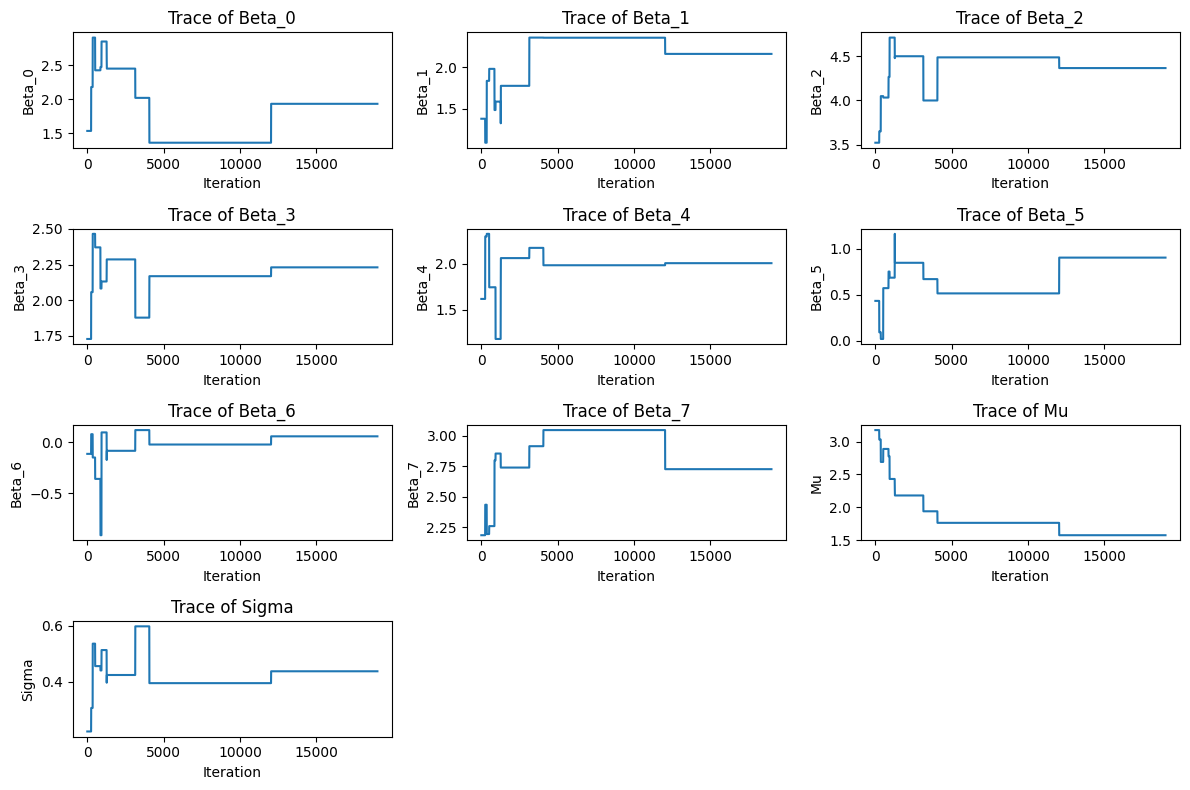

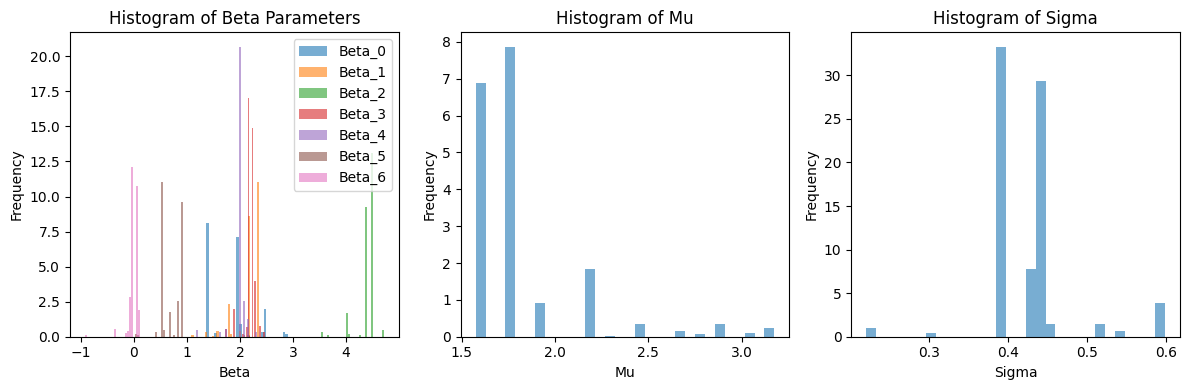

In [58]:
# Set initial parameters and proposal standard deviation
#init_beta = np.concatenate(true_beta_0, true_beta)
initial_params = np.concatenate([np.random.normal(size=n_features+1), [0, 1]])  # Initial beta parameters, mu, and sigma
proposal_sd = 0.5

# Run Metropolis-Hastings algorithm
n_iter = 20000
chain, post = metropolis_hastings(initial_params, proposal_sd, n_iter, X, y)

# Burn-in (discard first part of the chain)
burn_in = 1000
burned_chain = chain[burn_in:]

# Extract beta parameters, mu, and sigma from the chain
beta_samples, mu_samples, sigma_samples = burned_chain[:, :-2], burned_chain[:, -2], burned_chain[:, -1]

# Plot the traces and histograms of beta parameters, mu, and sigma
plt.figure(figsize=(12, 8))

beta_vals = beta_samples.shape[1]

for i in range(beta_vals):
    plt.subplot(4, 3, i+1)
    plt.plot(beta_samples[:, i])
    plt.xlabel('Iteration')
    plt.ylabel(f'Beta_{i}')
    plt.title(f'Trace of Beta_{i}')

plt.subplot(4, 3, beta_vals+1)
plt.plot(mu_samples)
plt.xlabel('Iteration')
plt.ylabel('Mu')
plt.title('Trace of Mu')

plt.subplot(4, 3, beta_vals+2)
plt.plot(sigma_samples)
plt.xlabel('Iteration')
plt.ylabel('Sigma')
plt.title('Trace of Sigma')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
for i in range(n_features):
    plt.hist(beta_samples[:, i], bins=30, density=True, alpha=0.6, label=f'Beta_{i}')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.title('Histogram of Beta Parameters')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(mu_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Mu')
plt.ylabel('Frequency')
plt.title('Histogram of Mu')

plt.subplot(1, 3, 3)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.title('Histogram of Sigma')

plt.tight_layout()
plt.show()


In [59]:
# Extract the mode (most frequent value) from the parameter samples
mode_beta = np.median(beta_samples, axis=0)
mode_mu = np.median(mu_samples)
mode_sigma = np.median(sigma_samples)

print("Mode estimates:")
print("Beta:", mode_beta)
print("Mu:", mode_mu)
print("Sigma:", mode_sigma)

Mode estimates:
Beta: [ 1.93435183  2.16380667  4.48520679  2.1686189   2.00433892  0.6691041
 -0.02147791  2.73838147]
Mu: 1.763117608026253
Sigma: 0.4234453564231429


In [60]:
# Extract the MAP from the parameter samples
MAP_params = chain[np.argmax(post)]
MAP_beta = MAP_params[:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates:")
print("Beta:", MAP_beta)
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates:
Beta: [1.93435183 2.16380667 4.36431831 2.23061129 2.00433892 0.90273911
 0.05935215 2.72524376]
Mu: 1.5747131443849236
Sigma: 0.4368436030862076


In [61]:
print("True parameter values:")
print(f"Beta: {true_beta_0} {true_beta}")
print("Mu:", true_mu)
print("Sigma:", true_sigma)

True parameter values:
Beta: 0.5 [2.33262315 4.49599456 2.3348725  2.24408513 0.91852546 0.32878941
 3.0294515 ]
Mu: 0
Sigma: 1


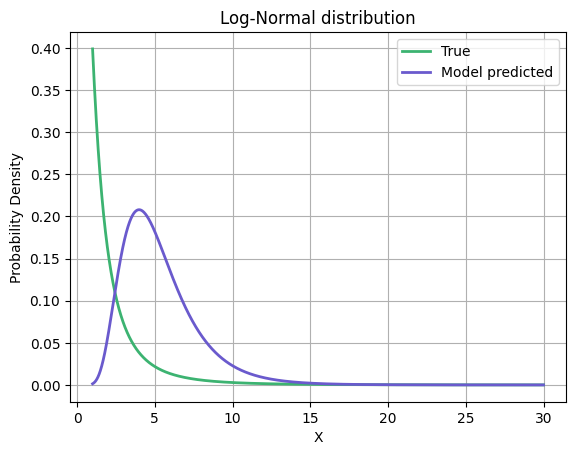

In [62]:
# Compare the true log-normal to that from the model 

# Parameters for log-normal distribution
shift = 0 # Shift 

x = np.arange(1, 30, 0.01)

pdf_x_true = shift_log_normal_pdf(x, shift, true_mu, true_sigma)
pdf_x_MAP = shift_log_normal_pdf(x, shift, MAP_mu, MAP_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x, pdf_x_true, '-', linewidth=2, color='mediumseagreen', label='True')
plt.plot(x, pdf_x_MAP, '-', linewidth=2, color='slateblue', label='Model predicted')

plt.title('Log-Normal distribution')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

### With the real data! 

In [63]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.001138


In [77]:
# The real dementia X and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']
X_covar = df_dem_plus[covar].values.reshape(-1,7)
#covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)

# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

In [78]:
#n_features = X_covar.shape[1]

#beta_0_guess = 0.2
#beta_initial = [beta_0_guess, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Set initial parameters and proposal standard deviation
initial_params = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]])  # Initial beta parameters, mu, and sigma
#initial_params = np.concatenate([beta_initial, [0, 0.25]])  # Initial beta parameters, mu, and sigma
proposal_sd = 1

In [79]:
# Run Metropolis-Hastings algorithm
n_iter = 20000
chain, post = metropolis_hastings(initial_params, proposal_sd, n_iter, X_covar, Y_data)

# Burn-in (discard first part of the chain)
burn_in = 1000
burned_chain = chain[burn_in:]

# Extract beta parameters, mu, and sigma from the chain
beta_samples, mu_samples, sigma_samples = burned_chain[:, :-2], burned_chain[:, -2], burned_chain[:, -1]

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/3435609620.py:11: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(likelihood))
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/2581223006.py:9: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/3435609620.py:11: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(likelihood))


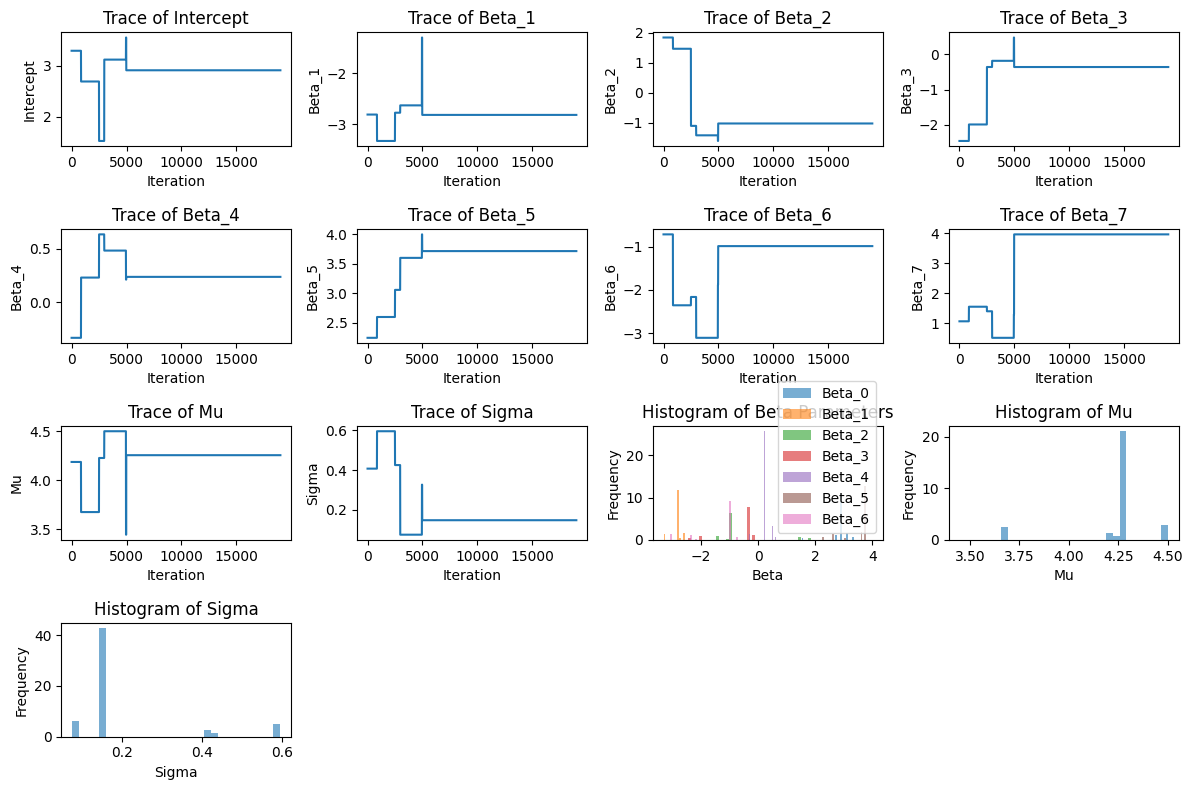

In [80]:
# Plot the traces and histograms of beta parameters, mu, and sigma
plt.figure(figsize=(12, 8))

plt.subplot(4, 4, 1)
plt.plot(beta_samples[:, 0])
plt.xlabel('Iteration')
plt.ylabel('Intercept')
plt.title('Trace of Intercept')

for i in range(1, n_features+1):
    plt.subplot(4, 4, i+1)
    plt.plot(beta_samples[:, i])
    plt.xlabel('Iteration')
    plt.ylabel(f'Beta_{i}')
    plt.title(f'Trace of Beta_{i}')

plt.subplot(4, 4, n_features+2)
plt.plot(mu_samples)
plt.xlabel('Iteration')
plt.ylabel('Mu')
plt.title('Trace of Mu')

plt.subplot(4, 4, n_features+3)
plt.plot(sigma_samples)
plt.xlabel('Iteration')
plt.ylabel('Sigma')
plt.title('Trace of Sigma')

plt.subplot(4, 4, n_features+4)
for i in range(n_features):
    plt.hist(beta_samples[:, i], bins=30, density=True, alpha=0.6, label=f'Beta_{i}')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.title('Histogram of Beta Parameters')
plt.legend()

plt.subplot(4, 4, n_features+5)
plt.hist(mu_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Mu')
plt.ylabel('Frequency')
plt.title('Histogram of Mu')

plt.subplot(4, 4, n_features+6)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.title('Histogram of Sigma')

plt.tight_layout()
plt.show()

In [81]:
print(post[np.argmax(post)])

-348584.8236608217


In [82]:
# Extract the MAP from the parameter samples
MAP_params = chain[np.argmax(post)]
MAP_beta = MAP_params[:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates:")
print("Intercept")
print(f'Intercept:{MAP_beta[0]}')
print("Beta")
for i, var in enumerate(covar):
    print(f'{var}:{MAP_beta[i+1]}')
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates:
Intercept
Intercept:2.9148070553244563
Beta
over_65_pc:-2.8149896618185073
female_pc:-1.0188486473755636
ALevel_plus_pc:-0.3595895783484956
white_pc:0.2379495959555397
HYP_afflicted_pc:3.7159740565041193
DM_afflicted_pc:-0.9858059465841336
STIA_afflicted_pc:3.962171771241036
Mu: 4.258033836312554
Sigma: 0.1481906607506811


In [105]:
params = [0.17, 0.02, 0.004, -0.004, -0.003, 0.015, -0.014, 0.1, 0.3, 0.5]
log_posterior(params, X_covar, Y_data)

(309, 1)
(309, 309)
norm constant: [[   7.47026821    1.24881371    1.69872956 ...    1.98850516
     2.22848296    1.6267813 ]
 [  -1.69056925   13.26625693   -7.31499391 ...   -4.49457566
    -3.61474127   -9.03587613]
 [  -4.03075603    2.38775447    4.83748931 ...    8.2689798
    14.97469041    4.2963749 ]
 ...
 [  -2.15730525    4.91751648 -114.54695704 ...  -10.58033737
    -6.72632905   57.78504743]
 [  -5.72673336    2.03137943    3.56898637 ...    5.14385566
     7.13001598    3.26554968]
 [  -1.82319826    8.44528672  -10.67515167 ...   -5.57226044
    -4.28054809  -14.78416779]]


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/482684901.py:12: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)


nan

In [138]:
log_likelihood(params, X_covar, Y_data)

shape of y_pred:(309,)
x shape:(309, 1)
shape of delta:(309,)
shifted x shape: (309,)
norm constant: (309,)


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/2191344967.py:15: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(np.subtract(x_shift.squeeze(), mu.squeeze()))**2))


nan

NOTE TO BEA

Need to investigate whether **2 and np.log are happening elementwise!!!!!

In [131]:
A = np.array([[1],[2]]).squeeze()
print(A.shape)
B = np.array([1,1]).T
print(B.shape)

A-B

(2,)
(2,)


array([0, 1])

In [87]:
# Compare the true log-normal to that from the model 

mode = log_norm_mode(MAP_mu, MAP_sigma)

# Parameters for log-normal distribution
shift = 0 # Shift 

x = np.arange(0, 3, 0.01)

pdf_x_MAP = shift_log_normal_pdf(x, shift, MAP_mu, MAP_sigma)

# Plot the log-normal probability density function (PDF)
plt.plot(x, pdf_x_MAP, '-', linewidth=2, color='slateblue', label='Model predicted')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.vlines(mode, ymin, ymax, color='seagreen', label='Log normal mode', linestyles='dotted')
plt.text(mode+0.5, xmax/2, f'Mode:{np.round(mode,2)}', color='seagreen')
plt.title('Log-Normal distribution')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/2581223006.py:8: RuntimeWarning: divide by zero encountered in divide
  norm_const = 1/((x_shift)*sigma*np.sqrt(2*np.pi))
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/2581223006.py:9: RuntimeWarning: divide by zero encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/2581223006.py:10: RuntimeWarning: invalid value encountered in multiply
  return norm_const*exp_part


SystemError: tile cannot extend outside image

<Figure size 640x480 with 1 Axes>

In [ ]:
# Define a function to compute the autocorrelation time
def autocorr_time(chain):
    acov = np.correlate(chain - np.mean(chain), chain - np.mean(chain), mode='full')
    acov /= np.max(acov)
    return np.sum(acov < 0.05)

# Compute the autocorrelation time for each parameter
autocorr_times = {
    f'Beta_{i}': autocorr_time(beta_samples[:, i]) for i in range(n_features)
}
autocorr_times['Mu'] = autocorr_time(mu_samples)
autocorr_times['Sigma'] = autocorr_time(sigma_samples)

# Print the autocorrelation times
print("Autocorrelation times:")
for param, acorr_time in autocorr_times.items():
    print(f"{param}: {acorr_time}")


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/3440952623.py:4: RuntimeWarning: invalid value encountered in divide
  acov /= np.max(acov)


Autocorrelation times:
Beta_0: 0
Beta_1: 0
Beta_2: 1900
Beta_3: 0
Beta_4: 0
Beta_5: 1900
Beta_6: 0
Mu: 0
Sigma: 0


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10521/2457591679.py:5: RuntimeWarning: invalid value encountered in divide
  autocorr /= autocorr[n-1]


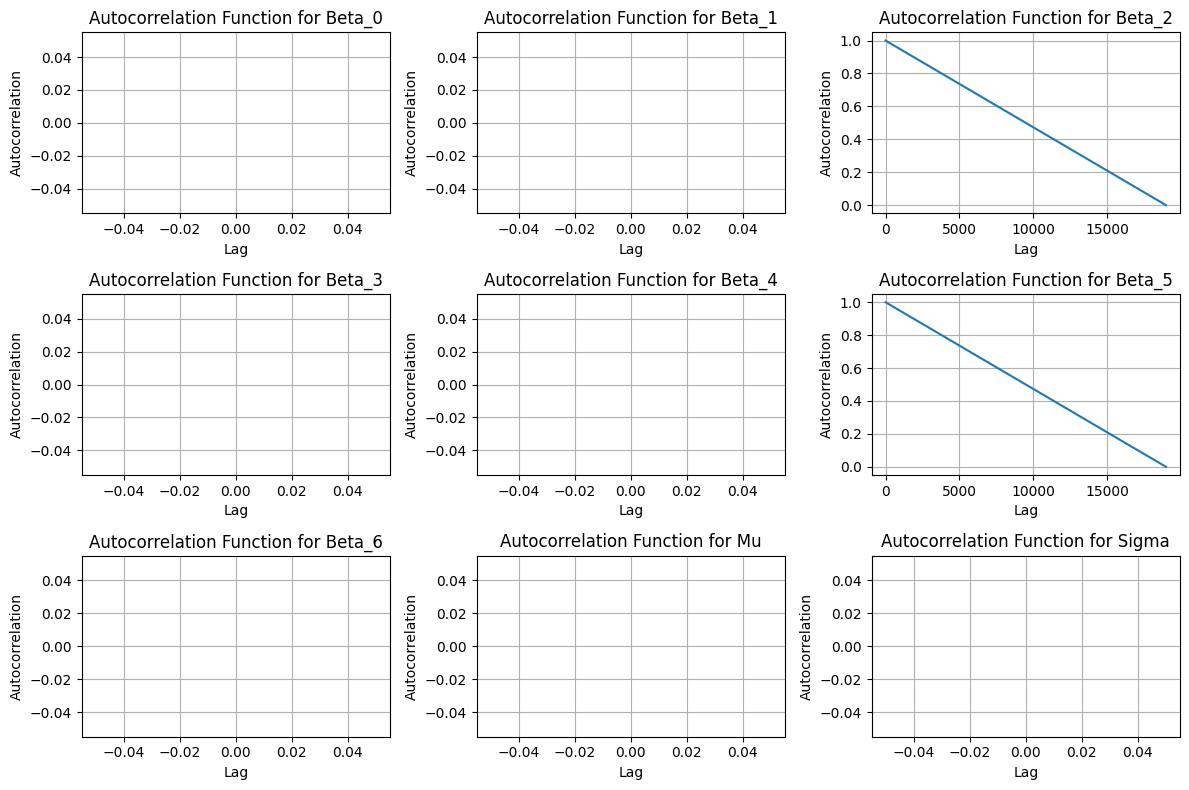

In [ ]:
# Define a function to compute the autocorrelation function
def autocorr_function(chain):
    n = len(chain)
    autocorr = np.correlate(chain - np.mean(chain), chain - np.mean(chain), mode='full')
    autocorr /= autocorr[n-1]
    return autocorr[n-1:]

# Plot the autocorrelation functions for each parameter
plt.figure(figsize=(12, 8))

for i in range(n_features):
    autocorr = autocorr_function(beta_samples[:, i])
    plt.subplot(3, 3, i+1)
    plt.plot(autocorr)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation Function for Beta_{i}')
    plt.grid()

autocorr = autocorr_function(mu_samples)
plt.subplot(3, 3, n_features+1)
plt.plot(autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function for Mu')
plt.grid()

autocorr = autocorr_function(sigma_samples)
plt.subplot(3, 3, n_features+2)
plt.plot(autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function for Sigma')
plt.grid()

plt.tight_layout()
plt.show()
